# CSCE633 Machine Learning - HW4

## Programming: Question 2: Image Classification using CNN in Pytorch (70 points)

### Import all the libraries

In [1]:
import os
import json
import tqdm
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split

### (a) Dataloader

Download the MNIST train and test dataset on Canvas. Implement a data loader with batch size and validation size as arguments. (HINT: You can check the documentation here: Creating a Custom Dataset for your files)

#### Read the data
Put the x_train.npy, x_test.npy, and y_train.npy under the root directory or inside a data folder.

In [2]:
train_data_path = "./data/x_train.npy"
train_label_path = "./data/y_train.npy"
test_data_path = "./data/x_test.npy"

if not os.path.exists(train_data_path):
    train_data_path = "./x_train.npy"
if not os.path.exists(train_label_path):
    train_label_path = "./y_train.npy"
if not os.path.exists(test_data_path):
    test_data_path = "./x_test.npy"
    
assert os.path.exists(train_data_path) and os.path.exists(train_label_path) and os.path.exists(test_data_path) , "Data not found"

print("Reading train data from: {}".format(train_data_path))
print("Reading train label from: {}".format(train_label_path))
print("Reading test data from: {}".format(test_data_path))


Reading train data from: ./data/x_train.npy
Reading train label from: ./data/y_train.npy
Reading test data from: ./data/x_test.npy


Implement a data loader with batch size and validation size as arguments

In [3]:
class MNIST_Dataset(Dataset):
    def __init__(self, data, label=None):
        self.data = data
        self.label = label
    def __getitem__(self, idx):
        d = self.data[idx]
        if d.ndim == 1:
            d = d.reshape(np.sqrt(d.shape[0]).astype(int), -1)
        if self.label is not None:
            return d, self.label[idx]
        else:
            return d
        
    def __len__(self):
        return len(self.data)

def get_data_loader(dataset, batch_size, validation_size=None, shuffle=False):
    if validation_size is not None:
        train_size = int(len(dataset) * (1 - validation_size))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
        return train_loader, val_loader
    else:
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
        return loader

In [4]:
train_data = np.load(train_data_path)
train_label = np.load(train_label_path)
test_data = np.load(test_data_path)

### (b) Data Exploration

Pick one example from each digit and visualize them.


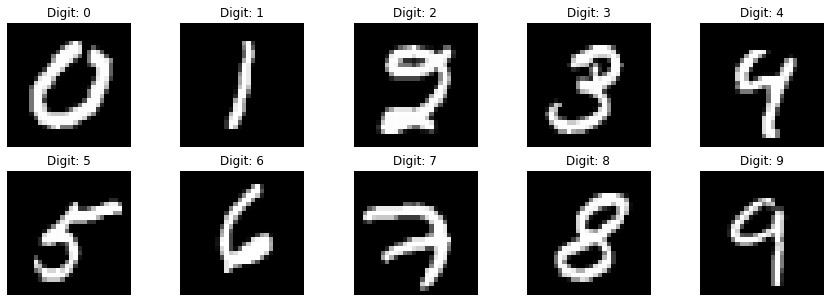

In [5]:
num_digits = len(set(train_label))
fig, ax = plt.subplots(2, num_digits//2, figsize=(15, 5))
for i in range(num_digits):
    sample_data = train_data[train_label == i][0]
    ax[i//5, i%5].imshow(sample_data.reshape(28, 28), cmap='gray')
    ax[i//5, i%5].set_title("Digit: {}".format(i))
    ax[i//5, i%5].axis('off')
plt.show()

Count the number of samples per digit in the original training data. Is the data distribution balanced? 

Histogram Table
               0      1     2      3     4     5     6      7     8     9
Digit                                                                    
# samples   5923   6742  5958   6131  5842  5421  5918   6265  5851  5949
Percentage  9.9%  11.2%  9.9%  10.2%  9.7%  9.0%  9.9%  10.4%  9.8%  9.9%


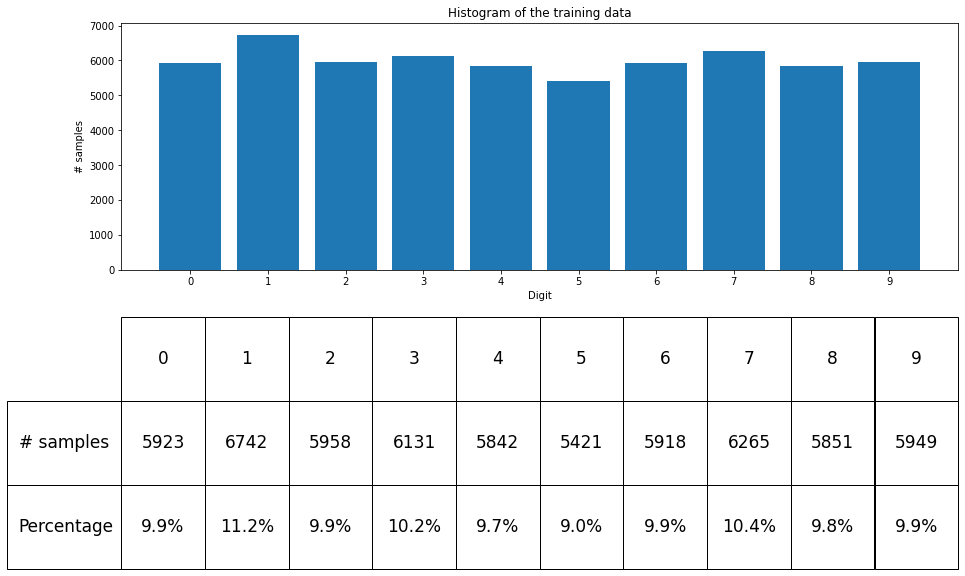

Average percentage of samples per digit: 10.0%
Standard deviation of percentage of samples per digit: 0.5%


In [6]:
hist_train = np.histogram(train_label, bins=np.arange(num_digits+1))[0]

hist_df = pd.DataFrame(columns=["Digit"]+np.arange(num_digits).tolist())
hist_df.loc[len(hist_df)] = ["# samples"] + hist_train.tolist()
hist_df.loc[len(hist_df)] = ["Percentage"] + ["{:.1f}%".format(v) for v in 100*hist_train/np.sum(hist_train).tolist()]
hist_df = hist_df.set_index("Digit")
print("Histogram Table")
print(hist_df)


# Plotting the histogram and the table
fig, axes = plt.subplots(2, 1, figsize=(15, 10))  # Adjust the figure size as necessary
axes[0].bar(np.arange(num_digits), hist_train)
axes[0].set_xticks(np.arange(num_digits))
axes[0].set_xlabel("Digit")
axes[0].set_ylabel("# samples")
axes[0].set_title("Histogram of the training data")

axes[1].axis('off')  # Hide the axes
tbl = axes[1].table(cellText=hist_df.values, colLabels=hist_df.columns, rowLabels=hist_df.index, loc='center', cellLoc='center')
# increase the table in vertical direction
tbl.scale(1, 7)
tbl.auto_set_font_size(False)
tbl.set_fontsize(17)
plt.show()

print("Average percentage of samples per digit: {:.1f}%".format(100*np.mean(hist_train)/len(train_label)))
print("Standard deviation of percentage of samples per digit: {:.1f}%".format(100*np.std(hist_train)/len(train_label)))

In this analysis, I visualize the distribution with a histogram and calculate the percentage of each digit in the training data to observe its distribution. We can observe that each digit represents approximately 10% of the training data. Therefore, the data is distributed relatively evenly.

### (c) Data Split

Split original training data into 80% for training and 20% validation datasets.

Use the get_data_loader function we created previously.

In [7]:
batch_size = 64
validation_size = 0.2

train_dataset = MNIST_Dataset(train_data, train_label)
train_loader, val_loader = get_data_loader(train_dataset, batch_size, validation_size=validation_size, shuffle=True)
print("Number of training samples: {}".format(len(train_loader.dataset)))
print("Number of validation samples: {}".format(len(val_loader.dataset)))

Number of training samples: 48000
Number of validation samples: 12000


### (d) Modeling

Implement a convolutional neural network to classify the digits in the MNIST dataset. Experiment with at least 3 hyperparameters. You may experiment with different CNN hyper-parameters, e.g. num of layers, filter size, stride, activation function, dropout, weight regularization, etc. Use the validation data to decide which combination of hyperparameters is best. Report the final classification accuracy on the validation dataset.

#### Define the model

In [8]:
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, maxpool=True, dropout_rate=0.0):
        super(conv_block, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        if dropout_rate > 0:
            layers.append(nn.Dropout(dropout_rate))
            
        if maxpool:
            layers.append(nn.MaxPool2d(2))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class NaiveModel(nn.Module):
    def __init__(self, num_classes, config):
        super(NaiveModel, self).__init__()
        num_layers = config["num_layers"]
        num_filters = config["num_filters"]
        kernel_size = config["kernel_size"]
        dropout_rate = config["dropout_rate"]

        # Initial in_channels = 1 for the first layer
        layers = [conv_block(1, num_filters, kernel_size, maxpool=True, dropout_rate=dropout_rate)]
        for _ in range(1, num_layers):
            layers.append(conv_block(num_filters, num_filters, kernel_size, maxpool=True, dropout_rate=dropout_rate))
        
        self.cnn_layers = nn.Sequential(*layers)

        # Dynamically calculate FC layer's input size
        self.fc_in_features = self._calculate_fc_in_features(1, 28, 28)  # Assuming 1x28x28 input images
        self.fc = nn.Linear(self.fc_in_features, num_classes)

    def _calculate_fc_in_features(self, channels, height, width):
        dummy_input = torch.randn(1, channels, height, width)
        output = self.cnn_layers(dummy_input)
        return int(torch.numel(output) / output.shape[0])

    def forward(self, x, return_features=False):
        features = []
        for layer in self.cnn_layers:
            x = layer(x)
            if return_features:
                features.append(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        if return_features:
            return x, features
        return x

    def predict(self, x):
        return self.forward(x).argmax(dim=1)

In [9]:
def train(model, train_loader, val_loader, config, verbose=True, plot=True):

    num_epochs = config["num_epochs"]
    lr = config["lr"]
    weight_decay = config["weight_decay"] # L2 regularization

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        correct = 0
        total = 0
        for (data, label) in train_loader:
            optimizer.zero_grad()

            data = Variable(data).unsqueeze(1).float()
            label = Variable(label).long()
            output = model(data)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(correct/total)
        
        model.eval()
        epoch_val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for (data, label) in val_loader:
                data = Variable(data).unsqueeze(1).float()
                label = Variable(label).long()

                output = model(data)
                loss = criterion(output, label)
                epoch_val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total += label.size(0)
                correct += (predicted == label).sum().item()
        val_loss.append(epoch_val_loss/len(val_loader))
        val_acc.append(correct/total)
        
        if verbose:
            print("Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}".format(
                epoch, train_loss[-1], train_acc[-1], val_loss[-1], val_acc[-1]))
        
        if plot:
            from IPython.display import clear_output
            plt.ion()  # Turn on interactive mode
            fig, ax = plt.subplots(1, 2, figsize=(15, 5))
            ax[0].plot(np.arange(epoch+1), train_loss, label="Train Loss")
            ax[0].plot(np.arange(epoch+1), val_loss, label="Val Loss")
            ax[0].set_xlabel("Epoch")
            ax[0].set_ylabel("Loss")
            ax[0].legend()
            ax[0].set_title("Loss")

            ax[1].plot(np.arange(epoch+1), train_acc, label="Train Acc")
            ax[1].plot(np.arange(epoch+1), val_acc, label="Val Acc")
            ax[1].set_xlabel("Epoch")
            ax[1].set_ylabel("Accuracy")    
            ax[1].legend()
            ax[1].set_title("Accuracy")
            plt.show()
            clear_output(wait=True)
        
    return train_loss, val_loss, train_acc, val_acc

#### Experiment on a naive model

We initially experimented with a very simple model configuration:
* CNN blocks: 2
* CNN filters per block: 10
* Kernel size: 3x3
* Training epochs: 10
* Learning rate: 0.001, utilizing the Adam optimizer

In each convolutional block, we perform a sequence of operations: one convolution, followed by batch normalization, and then apply the ReLU activation function. We also employ a 2D max pooling operation with a kernel size of 2 to reduce the spatial dimensions of the image in the convolution block. Finally, the output from the convolutional layers is flattened and passed through a fully connected layer to produce the final output corresponding to the number of classes. Here is the model structure in detail:

In [10]:
config = {
    # Model Hyperparameters
    "num_layers": 2,
    "num_filters": 10,
    "kernel_size": 3,
    "dropout_rate": 0.0,

    # Training hyperparameters here
    "num_epochs": 10,
    "lr": 0.001,
    "weight_decay": 0.0
}

naive_model = NaiveModel(num_digits, config)
print(naive_model)
print("Number of parameters: {}".format(sum(p.numel() for p in naive_model.parameters() if p.requires_grad)))


NaiveModel(
  (cnn_layers): Sequential(
    (0): conv_block(
      (block): Sequential(
        (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): conv_block(
      (block): Sequential(
        (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
  )
  (fc): Linear(in_features=490, out_features=10, bias=True)
)
Number of parameters: 5960


Epoch: 9, Train Loss: 0.0273, Train Acc: 0.9911, Val Loss: 0.0435, Val Acc: 0.9860


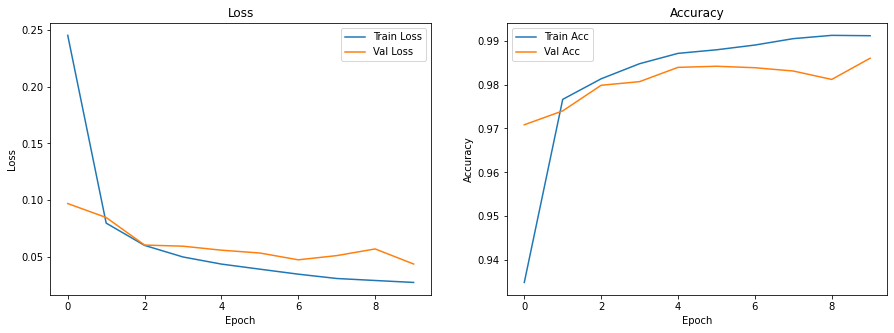

In [11]:
train_loss, val_loss, train_acc, val_acc = train(naive_model, train_loader, val_loader, config, verbose=True, plot=True)

#### Perform a grid search to find the best hyperparameters for the model

I experiment with different numbers of CNN layers, kernel sizes, dropout rates, and whether to use regularization, while fixing the number of filters for each convolution block and the number of epochs and learning rate for training.

In [12]:
num_layers_opt = [2,3]
num_filters_opt = [10]
kernel_size_opt = [3,5]
dropout_rate_opt = [0.0, 0.2]
regularization_opt = [0.0, 0.001]

best_val_acc = 0
best_config = None
best_model = None

ckpt_dir = "checkpoints"
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

for num_layers in num_layers_opt:
    for num_filters in num_filters_opt:
        for kernel_size in kernel_size_opt:
            for dropout_rate in dropout_rate_opt:
                for weight_decay in regularization_opt:
                    print("Training model with num_layers={}, num_filters={}, kernel_size={}, dropout_rate={}, weight_decay={}".format(
                        num_layers, num_filters, kernel_size, dropout_rate, weight_decay))
                    config = {
                        "num_layers": num_layers,
                        "num_filters": num_filters,
                        "kernel_size": kernel_size,
                        "dropout_rate": dropout_rate,
                        "num_epochs": 10,
                        "lr": 0.001,
                        "weight_decay": weight_decay
                    }
                    model = NaiveModel(num_digits, config)
                    train_loss, val_loss, train_acc, val_acc = train(model, train_loader, val_loader, config, verbose=True, plot=False)
                    if val_acc[-1] > best_val_acc:
                        best_val_acc = val_acc[-1]
                        best_config = config
                        best_model = model
                    
                    print("=====================================")

# Save the best model and config
torch.save(best_model.state_dict(), os.path.join(ckpt_dir, "best_model.pth"))
with open(os.path.join(ckpt_dir, "best_config.json"), "w") as f:
    json.dump(best_config, f, indent=4)


Training model with num_layers=2, num_filters=10, kernel_size=3, dropout_rate=0.0, weight_decay=0.0
Epoch: 0, Train Loss: 0.2456, Train Acc: 0.9322, Val Loss: 0.1014, Val Acc: 0.9686
Epoch: 1, Train Loss: 0.0769, Train Acc: 0.9772, Val Loss: 0.0717, Val Acc: 0.9778
Epoch: 2, Train Loss: 0.0598, Train Acc: 0.9818, Val Loss: 0.0596, Val Acc: 0.9815
Epoch: 3, Train Loss: 0.0505, Train Acc: 0.9850, Val Loss: 0.0588, Val Acc: 0.9818
Epoch: 4, Train Loss: 0.0450, Train Acc: 0.9857, Val Loss: 0.0654, Val Acc: 0.9795
Epoch: 5, Train Loss: 0.0406, Train Acc: 0.9879, Val Loss: 0.0539, Val Acc: 0.9837
Epoch: 6, Train Loss: 0.0370, Train Acc: 0.9886, Val Loss: 0.0482, Val Acc: 0.9853
Epoch: 7, Train Loss: 0.0335, Train Acc: 0.9890, Val Loss: 0.0502, Val Acc: 0.9851
Epoch: 8, Train Loss: 0.0308, Train Acc: 0.9902, Val Loss: 0.0516, Val Acc: 0.9841
Epoch: 9, Train Loss: 0.0284, Train Acc: 0.9914, Val Loss: 0.0583, Val Acc: 0.9832
Training model with num_layers=2, num_filters=10, kernel_size=3, dropo

####

### (g) Inference 

Use the best fine-tuned model for inference on the test dataset. Save your predic- tions for every row of the test data in a CSV file with the name FirstName_LastName_Preds.csv (Do not shuffle the test data)

In [13]:
print("Best validation accuracy: {:.4f}".format(best_val_acc))
print("Best configuration:")
print(best_config)
print("Best model:")
print(best_model)

Best validation accuracy: 0.9882
Best configuration:
{'num_layers': 2, 'num_filters': 10, 'kernel_size': 5, 'dropout_rate': 0.0, 'num_epochs': 10, 'lr': 0.001, 'weight_decay': 0.0}
Best model:
NaiveModel(
  (cnn_layers): Sequential(
    (0): conv_block(
      (block): Sequential(
        (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): conv_block(
      (block): Sequential(
        (0): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
  )
  (fc): Linear(in_features=250, out_features=10, bias=True)
)


   pred_cnn
0         1
1         2
2         2
3         5
4         3
Saving the predictions to: ./Mu-Ruei_Tseng_Preds.csv


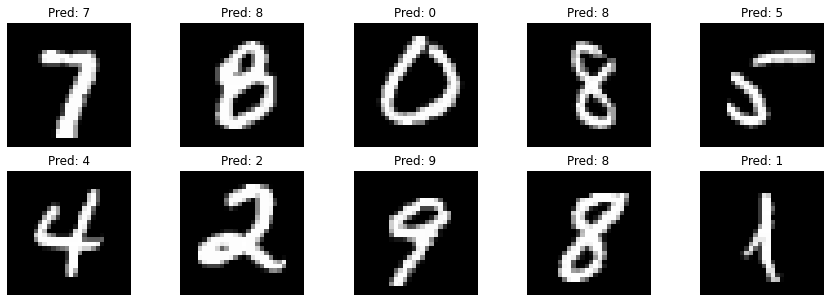

In [14]:
test_dataset = MNIST_Dataset(test_data)
test_loader = get_data_loader(test_dataset, batch_size, shuffle=False)

best_model.eval()
predictions = []
with torch.no_grad():
    for data in test_loader:
        data = Variable(data).unsqueeze(1).float()
        predicted = best_model.predict(data)
        predictions += predicted.tolist()

predictions_df = pd.DataFrame(columns=["pred_cnn"])

predictions_df["pred_cnn"] = predictions

print(predictions_df.head(n=5))
out_path = "./Mu-Ruei_Tseng_Preds.csv"
print("Saving the predictions to: {}".format(out_path))
predictions_df.to_csv(out_path, index=False)

# Visualize the predictions
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
for i in range(10):
    idx = np.random.randint(len(test_data))
    sample_data = test_data[idx]
    ax[i//5, i%5].imshow(sample_data.reshape(28, 28), cmap='gray')
    ax[i//5, i%5].set_title("Pred: {}".format(predictions[idx]))
    ax[i//5, i%5].axis('off')


### BONUS(+10 points): Filter Visualization
Randomly pick an image from the training set. Visualize the feature maps corresponding to all convolution filters after the first and last convolution layers.

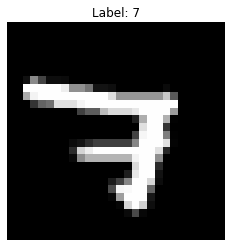

First layer features shape: torch.Size([1, 10, 13, 13])


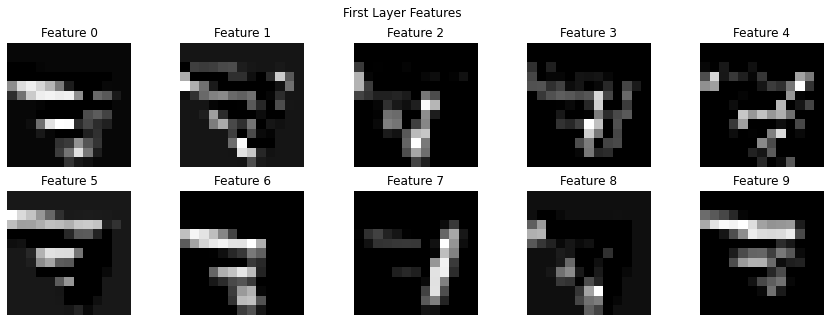

Last layer features shape: torch.Size([1, 10, 5, 5])


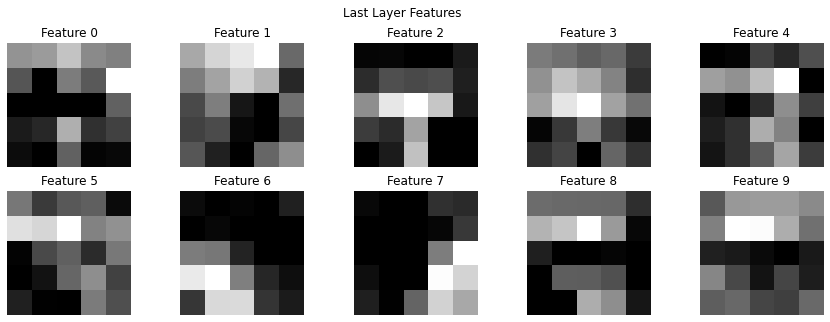

In [15]:
sample_data, sample_label = next(iter(train_loader))
sample_data = sample_data[0]
sample_label = sample_label[0]

plt.imshow(sample_data.numpy().reshape(28, 28), cmap='gray')
plt.title("Label: {}".format(sample_label))
plt.axis('off')
plt.show()

best_model.eval()
sample_data = Variable(sample_data).unsqueeze(0).unsqueeze(0).float()
output, features = best_model(sample_data, return_features=True)

first_layer_features = features[0]
last_layer_features = features[-1]

print("First layer features shape: {}".format(first_layer_features.shape))
n_features = first_layer_features.shape[1]
fig, axes = plt.subplots(2, n_features//2, figsize=(15, 5))
for i in range(n_features):
    ax = axes[i//5, i%5]
    ax.imshow(first_layer_features[0, i].detach().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title("Feature {}".format(i))
plt.suptitle("First Layer Features")
plt.show()

print("Last layer features shape: {}".format(last_layer_features.shape))
n_features = last_layer_features.shape[1]
fig, axes = plt.subplots(2, n_features//2, figsize=(15, 5))
for i in range(n_features):
    ax = axes[i//5, i%5]
    ax.imshow(last_layer_features[0, i].detach().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title("Feature {}".format(i))
plt.suptitle("Last Layer Features")
plt.show()
